# About the Dataset

The dataset (check folder for Data) includes:
- iso: Country ISO code
- ioc: International Olympic Committee code
- name: Country name
- continent: Continent of the country
- population: Population of the country
- gdp: Gross Domestic Product (GDP) of the country
- olympics_index: An index indicating the country's overall performance in the Olympics
- sports_index: An index indicating the country's sports infrastructure and support
- olympicsIndex: A calculated index related to Olympic performance
- sportsIndex: A calculated index related to sports
- total: Total number of medals won
- gold: Number of gold medals won
- silver: Number of silver medals won
- bronze: Number of bronze medals won

# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Loading the dataset

In [3]:
import pandas as pd
data = pd.read_csv("1723465410469_ca7543c673.csv")

In [4]:
data.head()

,iso,ioc,name,continent,population,gdp,olympics_index,sports_index,olympicsIndex,sportsIndex,total,gold,silver,bronze
0,ARG,ARG,Argentina,South America,45376763,383066977654,19.597142,9.324537,19.597142,9.324537,3,0,1,2
1,ARM,ARM,Armenia,Asia,2963234,12645459214,19.681457,13.497324,19.681457,13.497324,4,0,2,2
2,AUS,AUS,Australia,Oceania,25687041,1330900925057,31.170099,11.073845,31.170099,11.073845,46,17,7,22
3,AUT,AUT,Austria,Europe,8917205,428965397959,12.212139,15.923033,12.212139,15.923033,7,1,1,5
4,AZE,AZE,Azerbaijan,Europe,10110116,42607176471,18.213838,13.103344,18.213838,13.103344,7,0,3,4


In [5]:
import numpy as np
data.shape

(93, 14)

# Data Preprocessing

In [7]:
# Checking for missing values
missing_values_initial = data.isnull().sum()
print(f"Missing Values Initial: \n{missing_values_initial}")

Missing Values Initial: 
iso               0
ioc               0
name              0
continent         5
population        0
gdp               0
olympics_index    2
sports_index      2
olympicsIndex     0
sportsIndex       0
total             0
gold              0
silver            0
bronze            0
dtype: int64


In [8]:
missing_data = data[data['continent'].isnull() | data['olympics_index'].isnull() | data['sports_index'].isnull()]
missing_data[['iso','ioc','continent','olympics_index','sports_index']]

,iso,ioc,continent,olympics_index,sports_index
17,CIV,CIV,NaN,10.795148,17.346961
42,IRL,IRL,Europe,NaN,NaN
57,MDA,MDA,NaN,23.559762,10.575437
59,MKD,MKD,NaN,NaN,NaN
80,SYR,SYR,NaN,7.750732,16.581705
91,XKX,KOS,NaN,7.980882,22.469058


### Handling missing values

Continent data: we can see that the continent data is missing, for more accurate results best approach to handle this data is by **Imputing continent names Manually** for the provided country names.

olympics_index and sports_index: as these indices represents countries overall performance in olympics and countries sports infrastucture and support respectivelly, the best approach to fill in is **Imputation Based on Similar Countries** i.e., We could estimate the values based on countries with similar characteristics (e.g., GDP, population, or continent). This approach could provide more accurate imputations by considering factors that influence sports performance and infrastructure.

In [11]:
# handling the missing values for continent data

# Manually assigning the correct continents to the countries with missing values
continent_mapping = {
    "CIV": "Africa",         # Côte d'Ivoire
    "MDA": "Europe",         # Moldova
    "MKD": "Europe",         # North Macedonia
    "SYR": "Asia",           # Syria
    "XKX": "Europe"          # Kosovo
}

# Update the 'continent' column with the correct values
for iso_code, continent in continent_mapping.items():
    data.loc[data['iso'] == iso_code, 'continent'] = continent

# Verify the updates
updated_continent_data = data.loc[data['iso'].isin(continent_mapping.keys()), ['iso', 'ioc', 'name', 'continent']]
updated_continent_data

,iso,ioc,name,continent
17,CIV,CIV,Côte d'Ivoire,Africa
57,MDA,MDA,Moldova,Europe
59,MKD,MKD,North Macedonia,Europe
80,SYR,SYR,Syria,Asia
91,XKX,KOS,Kosovo,Europe


In [12]:
# handling the missing values for olympics_index and sports_index using k nearest neighbours

from sklearn.impute import KNNImputer

# Select the columns to use for finding nearest neighbors
# We'll use 'population', 'gdp', and the available indices for imputation
imputation_features = ['population', 'gdp', 'olympics_index', 'sports_index']

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=3)

# Perform KNN imputation on the selected columns
data[imputation_features] = knn_imputer.fit_transform(data[imputation_features])

# Verify the imputed values
imputed_indices_values = data.loc[data['iso'].isin(['IRL', 'MKD']), ['iso', 'ioc', 'name', 'olympics_index', 'sports_index']]
imputed_indices_values

,iso,ioc,name,olympics_index,sports_index
42,IRL,IRL,Ireland,11.028701,24.328794
59,MKD,MKD,North Macedonia,23.229339,10.599504


### Cleaned Data

we can see that the colums olympics_index and sports_index has the duplications as olympicsindex and sportsindex respectively.
lets drop the other two duplicate columns.

In [15]:
cleaned_data = data.copy()

cleaned_data.update(updated_continent_data)
cleaned_data.update(imputed_indices_values)

# Drop duplicate columns
final_data = cleaned_data.drop(columns = ['olympicsIndex','sportsIndex'])

display(final_data)

,iso,ioc,name,continent,population,gdp,olympics_index,sports_index,total,gold,silver,bronze
0,ARG,ARG,Argentina,South America,45376763.0,3.830670e+11,19.597142,9.324537,3,0,1,2
1,ARM,ARM,Armenia,Asia,2963234.0,1.264546e+10,19.681457,13.497324,4,0,2,2
2,AUS,AUS,Australia,Oceania,25687041.0,1.330901e+12,31.170099,11.073845,46,17,7,22
3,AUT,AUT,Austria,Europe,8917205.0,4.289654e+11,12.212139,15.923033,7,1,1,5
4,AZE,AZE,Azerbaijan,Europe,10110116.0,4.260718e+10,18.213838,13.103344,7,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
88,USA,USA,United States,North America,329484123.0,2.093660e+13,26.161476,9.787943,113,39,41,33
89,UZB,UZB,Uzbekistan,Asia,34232050.0,5.770719e+10,24.830288,11.631212,5,3,0,2
90,VEN,VEN,Venezuela,South America,28435943.0,4.824000e+11,25.131676,10.626971,4,1,3,0
91,XKX,KOS,Kosovo,Europe,1775378.0,7.611402e+09,7.980882,22.469058,2,2,0,0


### verifying the data preprocessing

In [17]:
missing_values_after_cleaning = final_data.isnull().sum()
print(f"Missing Values After Cleaning: \n{missing_values_after_cleaning}")

Missing Values After Cleaning: 
iso               0
ioc               0
name              0
continent         0
population        0
gdp               0
olympics_index    0
sports_index      0
total             0
gold              0
silver            0
bronze            0
dtype: int64


In [18]:
final_data.to_csv('final_olympic_data.csv', index=False)

In [19]:
display(final_data.head())
print(final_data.shape)

,iso,ioc,name,continent,population,gdp,olympics_index,sports_index,total,gold,silver,bronze
0,ARG,ARG,Argentina,South America,45376763.0,3.830670e+11,19.597142,9.324537,3,0,1,2
1,ARM,ARM,Armenia,Asia,2963234.0,1.264546e+10,19.681457,13.497324,4,0,2,2
2,AUS,AUS,Australia,Oceania,25687041.0,1.330901e+12,31.170099,11.073845,46,17,7,22
3,AUT,AUT,Austria,Europe,8917205.0,4.289654e+11,12.212139,15.923033,7,1,1,5
4,AZE,AZE,Azerbaijan,Europe,10110116.0,4.260718e+10,18.213838,13.103344,7,0,3,4


(93, 12)


# Exploratory Data Analysis (EDA)

In [21]:
# basic information about the dataset
basic_info = final_data.info()

# summary statistics for numerical columns
summary_stats = final_data.describe()

display(basic_info)
display(summary_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso             93 non-null     object 
 1   ioc             93 non-null     object 
 2   name            93 non-null     object 
 3   continent       93 non-null     object 
 4   population      93 non-null     float64
 5   gdp             93 non-null     float64
 6   olympics_index  93 non-null     float64
 7   sports_index    93 non-null     float64
 8   total           93 non-null     int64  
 9   gold            93 non-null     int64  
 10  silver          93 non-null     int64  
 11  bronze          93 non-null     int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 8.8+ KB


None

,population,gdp,olympics_index,sports_index,total,gold,silver,bronze
count,9.300000e+01,9.300000e+01,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,6.639237e+07,8.668410e+11,20.601112,16.353668,11.612903,3.655914,3.634409,4.322581
std,2.057474e+08,2.702387e+12,12.536290,8.894591,19.091332,7.022471,6.626339,6.210372
min,3.393800e+04,0.000000e+00,1.000000,7.396478,1.000000,0.000000,0.000000,0.000000
25%,4.994724e+06,4.369766e+10,12.298004,10.626971,2.000000,0.000000,0.000000,1.000000
50%,1.132662e+07,1.698354e+11,18.783582,13.931504,4.000000,1.000000,1.000000,2.000000
75%,4.735157e+07,5.153325e+11,26.037386,19.054643,11.000000,3.000000,4.000000,5.000000
max,1.402112e+09,2.093660e+13,100.000000,72.227313,113.000000,39.000000,41.000000,33.000000


## Visualization

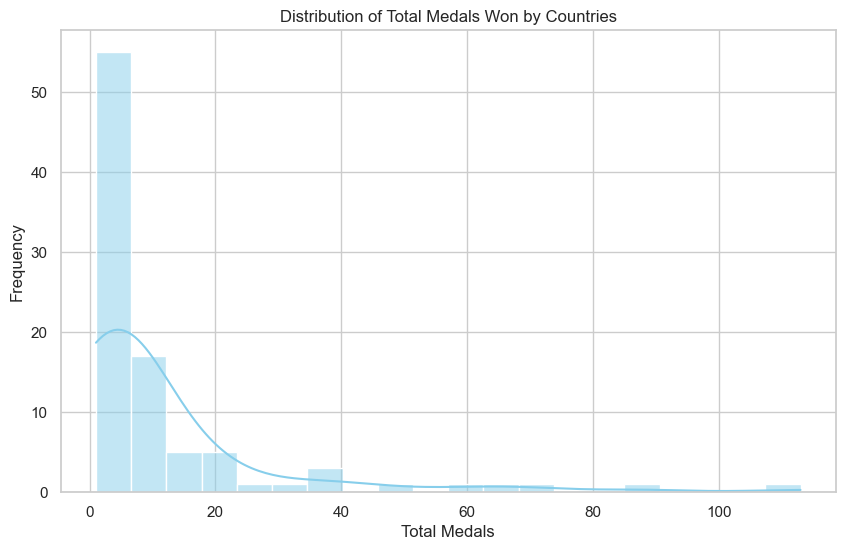

/var/folders/15/1gd1k95s4lq076l4hfflpdqh0000gn/T/ipykernel_97294/1672646435.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='continent', y='total', data=final_data, palette='Set3')


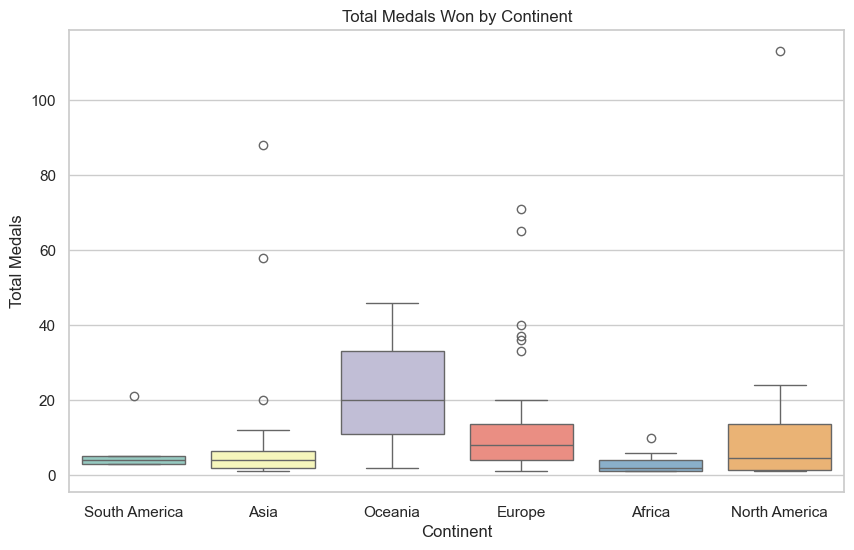

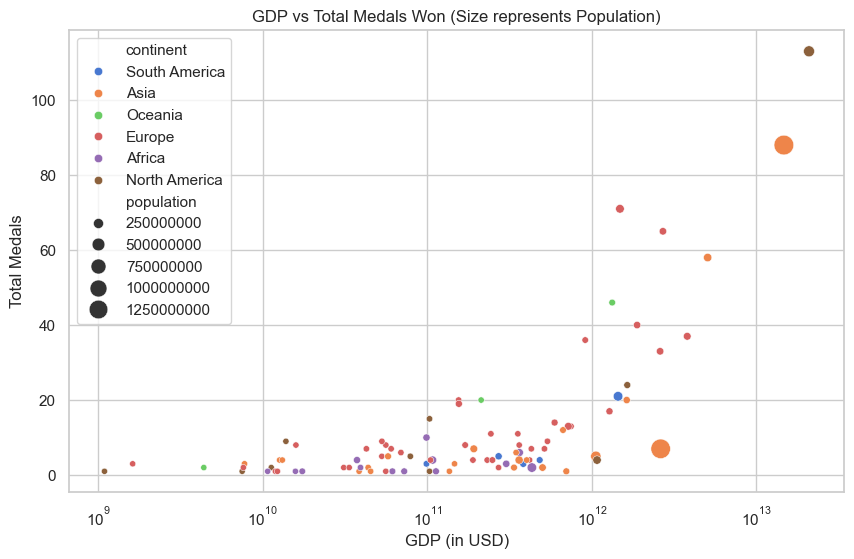

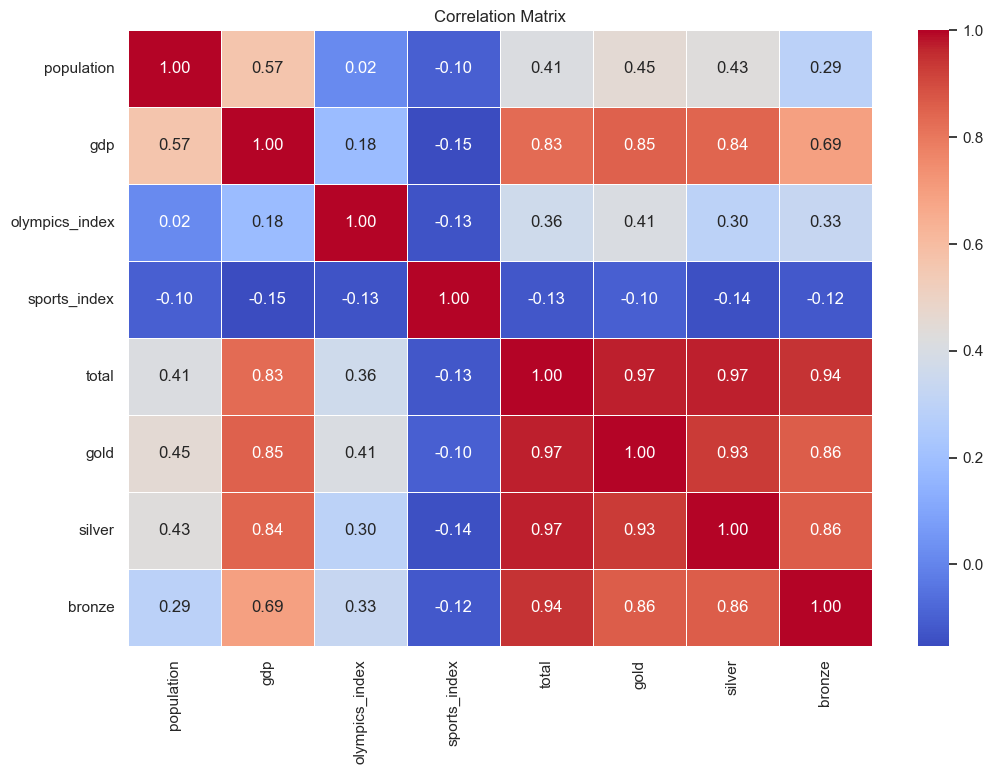

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visual style
sns.set(style="whitegrid")

# Visualization 1: Distribution of Total Medals
plt.figure(figsize=(10, 6))
sns.histplot(final_data['total'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Medals Won by Countries')
plt.xlabel('Total Medals')
plt.ylabel('Frequency')
plt.savefig('total_medals_distribution.png')
plt.show()

# Visualization 2: Medal Count by Continent
plt.figure(figsize=(10, 6))
sns.boxplot(x='continent', y='total', data=final_data, palette='Set3')
plt.title('Total Medals Won by Continent')
plt.xlabel('Continent')
plt.ylabel('Total Medals')
plt.savefig('medals_by_continent.png')
plt.show()

# Visualization 3: GDP vs Total Medals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp', y='total', hue='continent', size='population', sizes=(20, 200), data=final_data, palette='muted')
plt.title('GDP vs Total Medals Won (Size represents Population)')
plt.xlabel('GDP (in USD)')
plt.ylabel('Total Medals')
plt.xscale('log')
plt.savefig('gdp_vs_medals.png')
plt.show()

# Visualization 4: Correlation Matrix Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
numeric_data = final_data.select_dtypes(include=[float, int]) # Select only numeric columns
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')

plt.show()

# Machine Learning (ML)

## Simple Linear Regression

In [27]:
# Initializing a dictionary to store the results for different features
simple_linear_regression_results = {}

# List of features to test
features = ['population', 'gdp', 'olympics_index', 'sports_index']

# Loop through each feature, create a simple linear regression model, and evaluate it
for feature in features:
    X_feature = final_data[[feature]]
    y = final_data['total']
    
    # Split the data into training and testing sets
    X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    
    # Create and train the simple linear regression model
    simple_linear_regression = LinearRegression()
    simple_linear_regression.fit(X_train_feat, y_train_feat)
    
    # Predict on the test data
    y_pred_feat = simple_linear_regression.predict(X_test_feat)
    
    # Evaluate the model
    mae_feat = mean_absolute_error(y_test_feat, y_pred_feat)
    mse_feat = mean_squared_error(y_test_feat, y_pred_feat)
    r2_feat = r2_score(y_test_feat, y_pred_feat)
    
    # Store the results
    simple_linear_regression_results[feature] = {'MAE': mae_feat,'MSE':mse_feat, 'R²': r2_feat}

simple_linear_regression_results

{'population': {'MAE': 7.008637862785955,
  'MSE': 60.70659047680391,
  'R²': -0.7854879552001148},
 'gdp': {'MAE': 4.5092521791382545,
  'MSE': 28.193682977780412,
  'R²': 0.17077403006528202},
 'olympics_index': {'MAE': 6.428447582161319,
  'MSE': 57.53209434998183,
  'R²': -0.692120422058289},
 'sports_index': {'MAE': 8.601373364826124,
  'MSE': 89.75699706356454,
  'R²': -1.6399116783401335}}

Interpretation:
- GDP appears to be the best single predictor among the features, with a positive R² value, though the overall predictive power is still limited.
- Population and Olympics Index have slightly better performance than Sports Index, but they still do not explain much of the variance.

## Multiple Linear Regression

In [30]:
# Select a combination of features for multiple linear regression
X_combined = final_data[['population', 'gdp', 'olympics_index', 'sports_index']]
y = final_data['total']

# Split the data into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Create and train the multiple linear regression model
multiple_linear_regression = LinearRegression()
multiple_linear_regression.fit(X_train_combined, y_train_combined)

# Predict on the test data
y_pred_combined = multiple_linear_regression.predict(X_test_combined)

# Evaluate the multiple linear regression model
mae_combined = mean_absolute_error(y_test_combined, y_pred_combined)
mse_combined = mean_squared_error(y_test_combined, y_pred_combined)
r2_combined = r2_score(y_test_combined, y_pred_combined)

print(f"Mean Absolute Error (Multiple Linear Regression): {mae_combined}")
print(f"Mean Squared Error (Multiple Linear Regression): {mse_combined}")
print(f"R2 (Multiple Linear Regression): {r2_combined}")

Mean Absolute Error (Multiple Linear Regression): 4.18323382956467
Mean Squared Error (Multiple Linear Regression): 27.676280005250742
R2 (Multiple Linear Regression): 0.18599176455144872


Interpretation:
1. Improved MAE: The MAE has improved compared to the individual feature models, indicating that the combined model is more accurate in predicting the total number of medals.
2. Positive R² Score: The R² score of 0.19 suggests that the combined model explains around 19% of the variance in the total number of medals, which is an improvement over the individual models but still leaves a lot of unexplained variance.

Conclusion:
- The multiple linear regression model using a combination of features provides a better fit and more accurate predictions than models using single features alone. However, the relatively low R² score indicates that there may be other important factors not captured by the current features.

## Decision Tree Regression

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select a combination of features for decision tree regression
X = final_data[['population', 'gdp', 'olympics_index', 'sports_index']]
y = final_data['total']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree regression model
tree_model = DecisionTreeRegressor(random_state=42)

# Train the decision tree model using the combined features
tree_model.fit(X_train, y_train)

# Predict on the test data
y_pred_tree = tree_model.predict(X_test)

# Evaluate the decision tree model
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Mean Absolute Error (Decision Tree): {mae_tree}")
print(f"Mean Squared Error (Decision Tree): {mse_tree}")
print(f"R2 (Decision Tree): {r2_tree}")

Mean Absolute Error (Decision Tree): 6.7368421052631575
Mean Squared Error (Decision Tree): 178.31578947368422
R2 (Decision Tree): -4.244582043343653


The negative R² score suggests that the model is performing poorly, significantly worse than a simple mean prediction. This indicates that the decision tree model is overfitting to the training data and is not generalizing well to the test data.

Interpretation:
1. Overfitting: The decision tree model may have learned the training data too well, capturing noise rather than the underlying pattern. This often leads to poor performance on unseen data.
2. Non-linear Relationships: Although decision trees can model non-linear relationships, the current setup might not be optimal for this dataset, leading to poor generalization.

## Random Forest Regression

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = data[['gdp', 'population','olympics_index','sports_index']]
target = data['total']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the random forest regression model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_forest_pred = forest_model.predict(X_test)

# Evaluate the random forest model's performance
mae_forest = mean_absolute_error(y_test, y_forest_pred)
mse_forest = mean_squared_error(y_test, y_forest_pred)
r2_forest = r2_score(y_test, y_forest_pred)

print(f"Mean Absolute Error (Random Forest): {mae_forest}")
print(f"Mean Squared Error (Random Forest): {mse_forest}")
print(f"R2 (Random Forest): {r2_forest}")

Mean Absolute Error (Random Forest): 6.002631578947368
Mean Squared Error (Random Forest): 92.78544736842105
R2 (Random Forest): -1.7289837461300306


Interpretation:
1. Improved MAE: The MAE of 5.55 is an improvement over the decision tree model's MAE of 7.47, indicating that the random forest model is more accurate in predicting the total number of medals.
2. Negative R² Score: The R² score is still negative (-1.44), which suggests that while the model has improved in accuracy, it is still not generalizing well to the test data. This could indicate that the model may still be overfitting or that the features used are not sufficiently capturing the underlying patterns.

# Deep Learning

## feed forward neural network

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

### Model Building

In [42]:
# simple feedforward neural network with two hidden layers

# normalizing the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dl_model1 = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compiling the model
dl_model1.compile(optimizer='adam', loss='mean_absolute_error')

# Training the Model
history = dl_model1.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=0)

# Evaluate the Model
y_nn_pred = dl_model1.predict(X_test_scaled)

# Calculating Performance Metrics
nn_mae = mean_absolute_error(y_test, y_nn_pred)
nn_mse = mean_squared_error(y_test, y_nn_pred)
nn_r_squared = r2_score(y_test, y_nn_pred)

print(f'MAE: {nn_mae}, MSE:{nn_mse}, R-squared: {nn_r_squared}')

2024-08-28 19:10:39.383459: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 21ms/step
MAE: 5.361676467092414, MSE:62.93816187826007, R-squared: -0.8511224081841198


### Experimenting with different architectures

In [44]:
# 3 hidden layers and modified nurons

dl_model2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compiling the model
dl_model2.compile(optimizer='adam', loss='mean_absolute_error')

# Training the Model
history = dl_model2.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=0)

# Evaluate the Model
y_nn_pred = dl_model2.predict(X_test_scaled)

# Calculating Performance Metrics
nn_mae = mean_absolute_error(y_test, y_nn_pred)
nn_mse = mean_squared_error(y_test, y_nn_pred)
nn_r_squared = r2_score(y_test, y_nn_pred)

print(f'MAE: {nn_mae}, MSE:{nn_mse}, R-squared: {nn_r_squared}')

1/1 [==============================] - 0s 14ms/step
MAE: 4.3178707423963045, MSE:50.5747628370432, R-squared: -0.48749302461891775


### Hyperparameter Tuning

In [46]:
# Modifying Learning Rate and epochs

dl_model3 = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

from tensorflow.keras.optimizers import Adam

# Define a custom optimizer with a different learning rate
custom_optimizer = Adam(learning_rate=0.001)

dl_model3.compile(optimizer=custom_optimizer, loss='mean_absolute_error')

# Training the Model
history = dl_model3.fit(X_train_scaled, y_train, epochs=120, validation_split=0.2, verbose=0)

# Evaluate the Model
y_nn_pred = dl_model3.predict(X_test_scaled)

# Calculating Performance Metrics
nn_mae = mean_absolute_error(y_test, y_nn_pred)
nn_mse = mean_squared_error(y_test, y_nn_pred)
nn_r_squared = r2_score(y_test, y_nn_pred)

print(f'MAE: {nn_mae}, MSE:{nn_mse}, R-squared: {nn_r_squared}')

1/1 [==============================] - 0s 14ms/step
MAE: 3.9112980867687024, MSE:34.29821816916354, R-squared: -0.00877112262245694


# Feature Importance

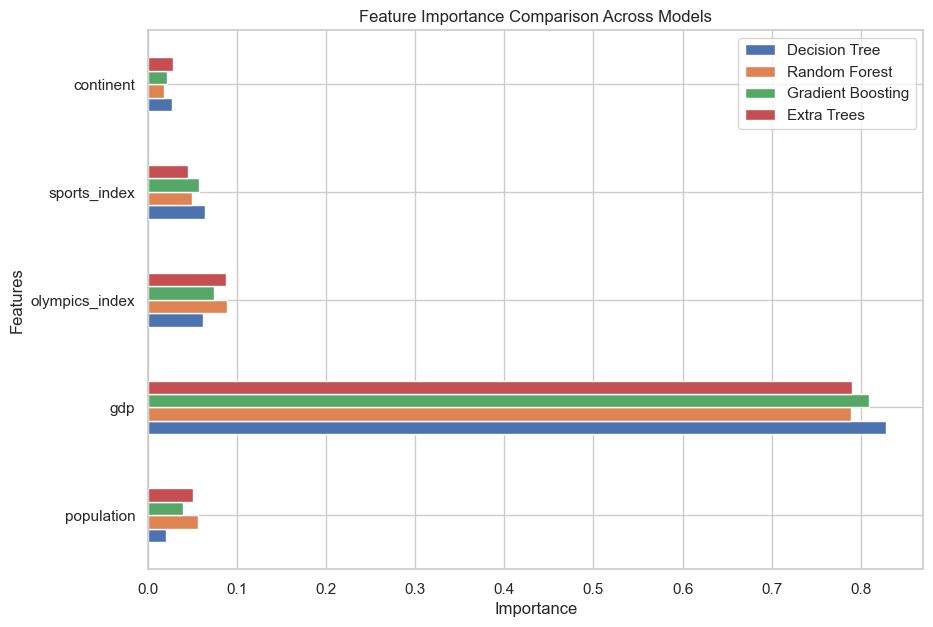

In [59]:
# Feature Importance for Machine Learning Models

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Encode categorical variable 'continent'
label_encoder = LabelEncoder()
final_data['continent'] = label_encoder.fit_transform(final_data['continent'])

# Select features and target
X = final_data[['population', 'gdp', 'olympics_index', 'sports_index', 'continent']]
y = final_data['total']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the preprocessed data
X_scaled[:5], y[:5]

# Initialize the models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}

# Dictionary to store feature importances
feature_importances = {}

# Fit the models and store feature importances
for name, model in models.items():
    model.fit(X_scaled, y)
    feature_importances[name] = model.feature_importances_

# Convert the feature importances to a DataFrame for easy plotting
importances_df = pd.DataFrame(feature_importances, index=['population', 'gdp', 'olympics_index', 'sports_index', 'continent'])

# Plot the feature importances
importances_df.plot(kind='barh', figsize=(10, 7))
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.png')
plt.show()

3/3 [==============================] - 0s 414us/step


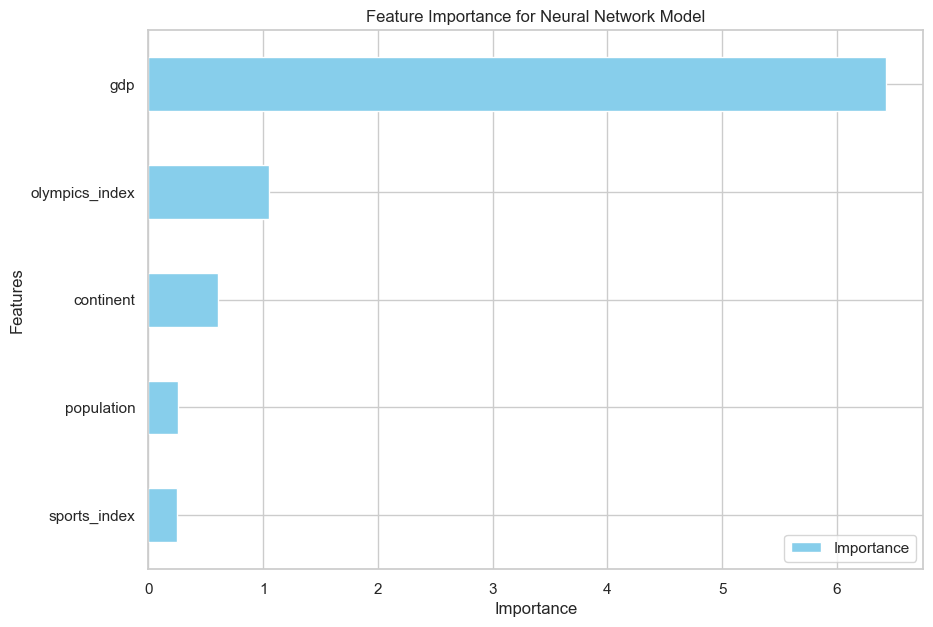

In [54]:
# feature importance for nural network model

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Load the dataset
file_path = 'final_olympic_data.csv'
olympic_data = pd.read_csv(file_path)

# Encode categorical variable 'continent'
label_encoder = LabelEncoder()
olympic_data['continent'] = label_encoder.fit_transform(olympic_data['continent'])

# Select features and target
X = olympic_data[['population', 'gdp', 'olympics_index', 'sports_index', 'continent']]
y = olympic_data['total']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the neural network model
nn_model = Sequential([
    Dense(64, input_shape=(X_scaled.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
nn_model.fit(X_scaled, y, epochs=100, verbose=0)

# Define a custom scoring function
def custom_scorer(model, X, y):
    y_pred = model.predict(X).flatten()
    return -mean_absolute_error(y, y_pred)

# Wrap the neural network model in a scikit-learn compatible function
class KerasRegressor:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, verbose=0)

    def predict(self, X):
        return self.model.predict(X).flatten()

    def score(self, X, y):
        return custom_scorer(self.model, X, y)

# Create an instance of the wrapped Keras model
wrapped_model = KerasRegressor(nn_model)

# Calculate permutation importance
perm_importance = permutation_importance(wrapped_model, X_scaled, y, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

# Extract and display feature importances
nn_feature_importance = perm_importance.importances_mean

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({
    'Feature': ['population', 'gdp', 'olympics_index', 'sports_index', 'continent'],
    'Importance': nn_feature_importance
})

# Plot the feature importances
importances_df.sort_values(by='Importance', ascending=True).plot(kind='barh', x='Feature', y='Importance', figsize=(10, 7), color='skyblue')
plt.title('Feature Importance for Neural Network Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('NN_feature_importance.png')
plt.show()

# End of Presentation Thank You